In [1]:
''' Download CelebA & Waterbird datasets '''

# CelebA
import os
import zipfile
import requests
import shutil
import tarfile
import argparse
from collections import defaultdict
import os
import pickle
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from PIL import Image

In [2]:
from intermediate_gen.utils import download_celeba
from intermediate_gen.utils import download_waterbirds

# takes around 3 minutes 
download_waterbirds()
# takes a long time to download and unzip (roughly an hour)
download_celeba()

Waterbirds dataset already exists
CelebA dataset already exists


In [3]:
# make a dataset.
from torchvision import transforms

from intermediate_gen.datasets import MyWaterBirdsDataset

DATASET_NAME = 'waterbirds'
# resnet-50 for imagenet tranform
img_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

assert DATASET_NAME in ['celeba', 'waterbirds'], f'Unknown dataset {DATASET_NAME}'
if DATASET_NAME == 'celeba':
    dataset_path = "/mnt/lustre/work/oh/owl661/intermediate-layer-generalization/examples/data/celeba"
elif DATASET_NAME == 'waterbirds':
    dataset_path = "./data/waterbirds/waterbird_complete95_forest2water2"
print(f'using dataset path {dataset_path}')
base_dataset = MyWaterBirdsDataset(dataset_path, remove_minority_groups=False, transform=img_transform)

using dataset path ./data/waterbirds/waterbird_complete95_forest2water2
11788
11788
Split set: train
y counts [3682 1113]
p counts [3554 1241]
group counts [3498  184   56 1057]
Split set: val
y counts [933 266]
p counts [600 599]
group counts [467 466 133 133]
Split set: test
y counts [4510 1284]
p counts [2897 2897]
group counts [2255 2255  642  642]


In [4]:
# make train, val and test datasets
train_dataset = torch.utils.data.Subset(base_dataset, base_dataset.train_idxs)
val_dataset = torch.utils.data.Subset(base_dataset, base_dataset.val_idxs)
test_dataset = torch.utils.data.Subset(base_dataset, base_dataset.test_idxs)

print(f'the length of the train dataset is {len(train_dataset)}')
print(f'the length of the val dataset is {len(val_dataset)}')
print(f'the length of the test dataset is {len(test_dataset)}')

# sanity check - print group counts for each dataset
for dataset_name, dataset in zip(['train', 'val', 'test'], [train_dataset, val_dataset, test_dataset]):
    counts = base_dataset.group_array[dataset.indices]
    print(f'for {dataset_name} dataset, group counts are {np.bincount(counts)}')    

the length of the train dataset is 4795
the length of the val dataset is 1199
the length of the test dataset is 5794
for train dataset, group counts are [3498  184   56 1057]
for val dataset, group counts are [467 466 133 133]
for test dataset, group counts are [2255 2255  642  642]


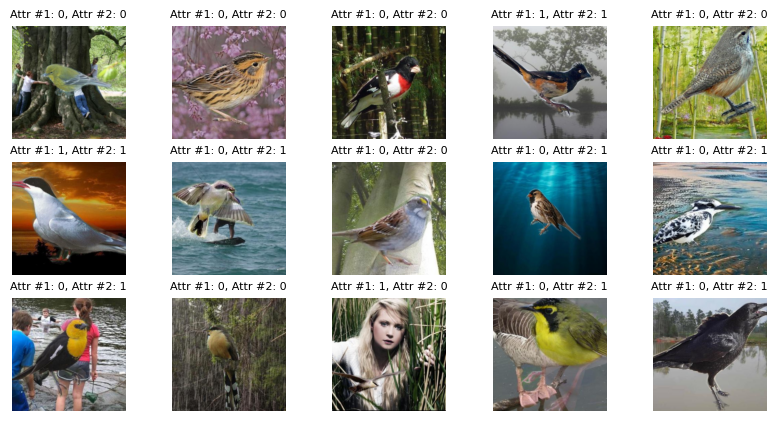

In [5]:
# visualize the samples
import matplotlib.pyplot as plt

n_show = 5
rng = np.random.RandomState(0)

fig, axs = plt.subplots(3, n_show, figsize=(10, 5))
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
for dataset_idx, (dataset_name, dataset) in enumerate(zip(['train', 'val', 'test'], [train_dataset, val_dataset, test_dataset])):
    axs[dataset_idx, 0].set_ylabel(dataset_name, fontsize=8)

    idx_take = rng.choice(len(dataset), n_show, replace=False)

    for j in range(n_show):
        i = idx_take[j]

        data  = dataset[i]
        img = data[0][0]

        group_info = data[0][2]

        img = img.permute(1, 2, 0).numpy()
        img = img * imagenet_std + imagenet_mean
        img = np.clip(img, 0, 1)
        
        axs[dataset_idx, j].imshow(img)
        axs[dataset_idx, j].axis('off')
        axs[dataset_idx, j].set_title(f'Attr #1: {group_info[0]}, Attr #2: {group_info[1]}', fontsize=8)
plt.show()


In [6]:
batch_size = 256
num_workers = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
''' The main piece of code for probing the model throughout the notebook '''

import torch
import torch.nn.functional as F

class LinearProbeModel(torch.nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        lr=0.0001,
        reg_type="l2",
        reg_weight=0.0,
        sgd_momentum=0.0,
        optimizer="SGD",
    ):
        super(LinearProbeModel, self).__init__()
        self.fc = torch.nn.Linear(input_size, output_size)
        self.lr = lr
        self.reg_type = reg_type
        self.reg_weight = reg_weight
        self.sgd_momentum = sgd_momentum

        # make an optimizer
        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=sgd_momentum)
        elif optimizer == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        return self.fc(x)

    def step_loss(self, x, y):
        ''' 
            x: representation from the backbone at the layer of interest (batch_size, feature_size)
            y: labels (batch_size)
        '''
        out = self.forward(x)
        accuracy = (torch.argmax(out, dim=1) == y).float().mean()

        loss = F.cross_entropy(out, y)

        # add regularization
        if self.reg_type == "l2":
            loss += self.reg_weight * torch.norm(self.fc.weight, p=2)
        elif self.reg_type == "l1":
            loss += self.reg_weight * torch.norm(self.fc.weight, p=1)

        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()
        return {
            "loss": loss.item(),
            "accuracy": accuracy.item(),
            "preds": out
        }


In [8]:
''' We use pretrained models from https://github.com/PolinaKirichenko/deep_feature_reweighting?tab=readme-ov-file (Last Layer Re-Training is Sufficient for Robustness to Spurious Correlations by Kirichenko, Polina and Izmailov, Pavel and Wilson, Andrew Gordon). '''

import gdown
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device {device}')

os.makedirs('models', exist_ok=True)
force_download = True
if DATASET_NAME == 'waterbirds':
    # the model corresponding to seed 0 is located at  https://drive.google.com/uc?export=download&id=1gZDj5oIEJZOo9WgPgyrELOCE_C_hh9vA
    # download the model
    url = 'https://drive.google.com/uc?export=download&id=1gZDj5oIEJZOo9WgPgyrELOCE_C_hh9vA'
    output_name = 'waterbirds_last_layer_retrained.pth'
elif DATASET_NAME == 'celeba':
    url = 'https://drive.google.com/uc?export=download&id=1m0J3Ss0etBpREnHWpTc_mbTYvzyocooD'
    output_name = 'celeba_last_layer_retrained.pth'

path_model = os.path.join('models', output_name)
if not os.path.exists(path_model) or force_download:
    print(f'Downloading model from {url}')
    gdown.download(url, path_model, quiet=False)
else:
    print(f'Model already exists at {path_model}')

# load the weights - import resnet50 first
from torchvision.models import resnet50

model = resnet50(pretrained=False, num_classes=2)
# read weights
weights = torch.load(path_model, map_location='cpu')
model.load_state_dict(weights)

# we freeze the model here to ensure that the backbone is not trained
for param in model.parameters():
    param.requires_grad = False
    
# get the model to the device
model.to(device)
model.eval()

Using device cuda


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1gZDj5oIEJZOo9WgPgyrELOCE_C_hh9vA
From (redirected): https://drive.google.com/uc?export=download&id=1gZDj5oIEJZOo9WgPgyrELOCE_C_hh9vA&confirm=t&uuid=67bdaff6-645a-4d44-9258-271fcaca079b
To: /mnt/lustre/work/oh/owl661/intermediate-layer-generalization/examples/models/waterbirds_last_layer_retrained.pth
100%|██████████| 94.4M/94.4M [00:04<00:00, 20.1MB/s]
/mnt/lustre/work/oh/owl661/interm-gen-conda/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/lustre/work/oh/owl661/interm-gen-conda/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
''' Zero-shot results: training classifiers on intermediate representations using the original CIFAR-10 dataset '''

def get_repr_dim_at_layer(model, layer_idx, init_input):
    ''' Get the shape of the representation at the layer of interest '''
    model.eval()
    
    for idx, layer in enumerate(model.children()):
        init_input = layer(init_input)
        if idx == layer_idx:
            return init_input
    raise ValueError(f'Layer index {layer_idx} is out of bounds for the model')

layers_to_probe = range(3,9)
assert all([0 <= layer_idx < len(list(model.children())) for layer_idx in layers_to_probe]) and max(layers_to_probe) == len(list(model.children())) - 2, f'Invalid layer indices: {layers_to_probe}; model has {len(list(model.children()))} layers'

lin_probes = {}

model.to(device)

if DATASET_NAME == 'celeba':
    LR = 1e-3
    REG_TYPE = 'l1'
    REG_WEIGHT = 1e-6
else:
    LR = 1e-4
    REG_TYPE = 'l1'
    REG_WEIGHT = 1e-2

for layer_idx in layers_to_probe:
    sample_input = torch.randn((1, 3, 224, 224), device=device) 
    repr_dim = get_repr_dim_at_layer(model, layer_idx, sample_input)
    print()
    print(f'Layer {layer_idx} representation dimension: {repr_dim.shape} (numel {repr_dim.numel()})')
    numel_items= repr_dim.numel()

    lin_probe_at_idx = LinearProbeModel(input_size=numel_items, output_size=2, lr=LR, reg_type=REG_TYPE, reg_weight=REG_WEIGHT, sgd_momentum=0.0, optimizer="adam")

    lin_probes[layer_idx] = lin_probe_at_idx

# we initialize the probe on the last layer with the same weights as the last layer of the backbone
lin_probes[8].fc.weight.data = model.fc.weight.data.clone()
lin_probes[8].fc.bias.data = model.fc.bias.data.clone()

for _, lin_probe in lin_probes.items():
    lin_probe.to(device)


Layer 3 representation dimension: torch.Size([1, 64, 56, 56]) (numel 200704)

Layer 4 representation dimension: torch.Size([1, 256, 56, 56]) (numel 802816)

Layer 5 representation dimension: torch.Size([1, 512, 28, 28]) (numel 401408)

Layer 6 representation dimension: torch.Size([1, 1024, 14, 14]) (numel 200704)

Layer 7 representation dimension: torch.Size([1, 2048, 7, 7]) (numel 100352)

Layer 8 representation dimension: torch.Size([1, 2048, 1, 1]) (numel 2048)


In [31]:
# Train the model and track the performance on the distribution shifts through time
@torch.no_grad()
def evaluate_model_on_dataset(model, dataloader, lin_probes):
    ''' Evaluate the model on the dataset and return the loss and accuracy for each layer.
        As a special case, we also evaluate the last layer of the backbone (referenced as 'll' in the results dict)
    '''
    with torch.no_grad():
        model.eval()
        results = {}
        for layer_idx, lin_probe in {**lin_probes, 'last-layer': None}.items():
            results[layer_idx] = {
                'loss': 0.0,
                'accuracy': 0.0,
                'preds': [],
                # for tracking per-group accuracies
                **{f'accuracy_a1={a1}_a2={a2}': 0.0 for a1 in range(2) for a2 in range(2)}
            }

        def get_stats_for_output(out, label):
            losses = F.cross_entropy(out, label, reduction='none').cpu() # (batch_size,)
            accuracies = (torch.argmax(out, dim=1) == label).cpu() # (batch_size,)
            return losses, accuracies
        
        def add_in_results(results, layer_idx, losses, accuracies, group_attrs):
            results[layer_idx]['loss'] += losses.sum().item()
            results[layer_idx]['accuracy'] += accuracies.sum().item()
            # print(group_attrs)
            for attr_1 in range(2):
                for attr_2 in range(2):
                    mask = (group_attrs[:, 0] == attr_1) & (group_attrs[:, 1] == attr_2)
                    if mask.sum() > 0:
                        results[layer_idx][f'accuracy_a1={attr_1}_a2={attr_2}'] += accuracies[mask].sum().item()
        attr_counts = torch.zeros(2, 2)
        for _, data in enumerate(dataloader):
            sample, label = data[0][0].to(device), data[0][1].to(device)
            x = sample
            group_attrs = data[0][2]
            
            # add in attr counts
            for attr_1 in range(2):
                for attr_2 in range(2):
                    mask = (group_attrs[:, 0] == attr_1) & (group_attrs[:, 1] == attr_2)
                    attr_counts[attr_1, attr_2] += mask.sum().item()
            
            for layer_idx, layer in enumerate(model.children()):
                # ResNet's .forward() reshapes the input at the 9th layer - 
                # since we aren't using their .forward() method,
                # we reshape it ourselves
                x = layer(x if layer_idx <= 8 else x.view(x.size(0), -1))

                if layer_idx in lin_probes:
                    x_detached_flat = x.detach().view(x.size(0), -1)
                    # get the prediction
                    lin_probe = lin_probes[layer_idx]
                    try:
                        out = lin_probe(x_detached_flat)
                    except:
                        print(f'Error at layer {layer_idx}: shape of input {x_detached_flat.shape}, shape of weight {lin_probe.fc.weight.shape}')
                    losses, accuracies = get_stats_for_output(out, label)
                    add_in_results(results, layer_idx, losses, accuracies, group_attrs)
                            
            # also pass the last layer of the backbone
            losses_last_layer, accuracies_last_layer = get_stats_for_output(x, label)
            add_in_results(results, 'last-layer', losses_last_layer, accuracies_last_layer, group_attrs)
            
        for layer_idx, _ in results.items():
            results[layer_idx]['loss'] = np.sum(results[layer_idx]['loss']) / len(dataloader.dataset)
            results[layer_idx]['accuracy'] = np.sum(results[layer_idx]['accuracy']) / len(dataloader.dataset)
            for attr_1 in range(2):
                for attr_2 in range(2):
                    results[layer_idx][f'accuracy_a1={attr_1}_a2={attr_2}'] /= attr_counts[attr_1, attr_2].item()
        return results

In [32]:
torch.cuda.empty_cache()

In [33]:
results_all_shufts = {}
with torch.no_grad():
    # for dataset_name, dataset in zip(['train', 'val', 'test'], [train_dataloader, val_dataloader, test_dataloader]):
    for dataset_name, dataset in zip(['val', 'test'], [val_dataloader, test_dataloader]):
        results_all_shufts[dataset_name] = evaluate_model_on_dataset(model, dataset, lin_probes)
        print(f'For dataset {dataset_name}, results are {results_all_shufts[dataset_name]}')

For dataset val, results are {3: {'loss': 0.6549052667180333, 'accuracy': 0.6872393661384487, 'preds': [], 'accuracy_a1=0_a2=0': 0.8137044967880086, 'accuracy_a1=0_a2=1': 0.8562231759656652, 'accuracy_a1=1_a2=0': 0.13533834586466165, 'accuracy_a1=1_a2=1': 0.20300751879699247}, 4: {'loss': 0.6971351489909398, 'accuracy': 0.4845704753961635, 'preds': [], 'accuracy_a1=0_a2=0': 0.4068522483940043, 'accuracy_a1=0_a2=1': 0.5579399141630901, 'accuracy_a1=1_a2=0': 0.518796992481203, 'accuracy_a1=1_a2=1': 0.46616541353383456}, 5: {'loss': 0.6994216638967532, 'accuracy': 0.469557964970809, 'preds': [], 'accuracy_a1=0_a2=0': 0.5096359743040685, 'accuracy_a1=0_a2=1': 0.3969957081545064, 'accuracy_a1=1_a2=0': 0.47368421052631576, 'accuracy_a1=1_a2=1': 0.5789473684210527}, 6: {'loss': 0.6801600897680032, 'accuracy': 0.6188490408673895, 'preds': [], 'accuracy_a1=0_a2=0': 0.7473233404710921, 'accuracy_a1=0_a2=1': 0.6888412017167382, 'accuracy_a1=1_a2=0': 0.24060150375939848, 'accuracy_a1=1_a2=1': 0.30

In [34]:
# pretty print results
for dataset_name, results in results_all_shufts.items():
    print(f'For dataset {dataset_name}')
    for layer_idx, layer_results in results.items():
        print(f'Layer {layer_idx} results: {layer_results}')

    # print last layer's WGA
    wga_last_layer = np.min([results['last-layer'][f'accuracy_a1={a1}_a2={a2}'] for a1 in range(2) for a2 in range(2)])
    print(f'WGA for last layer: {wga_last_layer}')

    print()

# the model yields around 0.73 WGA for waterbirds

For dataset val
Layer 3 results: {'loss': 0.6549052667180333, 'accuracy': 0.6872393661384487, 'preds': [], 'accuracy_a1=0_a2=0': 0.8137044967880086, 'accuracy_a1=0_a2=1': 0.8562231759656652, 'accuracy_a1=1_a2=0': 0.13533834586466165, 'accuracy_a1=1_a2=1': 0.20300751879699247}
Layer 4 results: {'loss': 0.6971351489909398, 'accuracy': 0.4845704753961635, 'preds': [], 'accuracy_a1=0_a2=0': 0.4068522483940043, 'accuracy_a1=0_a2=1': 0.5579399141630901, 'accuracy_a1=1_a2=0': 0.518796992481203, 'accuracy_a1=1_a2=1': 0.46616541353383456}
Layer 5 results: {'loss': 0.6994216638967532, 'accuracy': 0.469557964970809, 'preds': [], 'accuracy_a1=0_a2=0': 0.5096359743040685, 'accuracy_a1=0_a2=1': 0.3969957081545064, 'accuracy_a1=1_a2=0': 0.47368421052631576, 'accuracy_a1=1_a2=1': 0.5789473684210527}
Layer 6 results: {'loss': 0.6801600897680032, 'accuracy': 0.6188490408673895, 'preds': [], 'accuracy_a1=0_a2=0': 0.7473233404710921, 'accuracy_a1=0_a2=1': 0.6888412017167382, 'accuracy_a1=1_a2=0': 0.240601

In [35]:
# Now, actually train the model using the original training data. We could pre-cache the representations for the layers of interest, but because the training is fast, we can do it on-the-fly.
# It takes around 5 minutes in total on a GPU. 

from tqdm import tqdm

num_epochs = 50 if DATASET_NAME == 'waterbirds' else 10

valid_perfs_per_shift_per_layer = {}
best_probe_per_shift = {}

for epoch in tqdm(range(num_epochs)):
    for _, data in enumerate(train_dataloader):
        sample, label = data[0][0].to(device), data[0][1].to(device)
        x = sample
        for layer_idx, layer in enumerate(model.children()):
            x = layer(x if layer_idx <= 8 else x.view(x.size(0), -1))
            if layer_idx in lin_probes:
                x_detached_flat = x.detach().view(x.size(0), -1)

                # get the prediction
                lin_probe = lin_probes[layer_idx]
                lin_probe.step_loss(x_detached_flat, label)
    # evaluation on validation set. 
    valid_results = evaluate_model_on_dataset(model, val_dataloader, lin_probes)

    for layer_name, layer_results in valid_results.items():
        # get the WGA
        WGA = np.min([layer_results[f'accuracy_a1={a1}_a2={a2}'] for a1 in range(2) for a2 in range(2)])
        if layer_name not in valid_perfs_per_shift_per_layer:
            valid_perfs_per_shift_per_layer[layer_name] = {
                'accuracy': -np.inf,
                'WGA': -np.inf,
            }
        if WGA > valid_perfs_per_shift_per_layer[layer_name]['WGA']:
            valid_perfs_per_shift_per_layer[layer_name] = {
                'accuracy': layer_results['accuracy'],
                'WGA': WGA,
                'epoch': epoch
            }
            if layer_name != 'last-layer':
                best_probe_per_shift[layer_name] = {k: v.cpu().clone() for k, v in lin_probes[layer_name].state_dict().items()}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [06:36<00:00,  7.93s/it]


In [36]:
# Evaluate the trained probes
results_all_shufts = {}
for layer_name, probe in best_probe_per_shift.items():
    lin_probes[int(layer_name)].load_state_dict(probe)
    lin_probes[int(layer_name)].to(device)
    
for dataset_name, dataset in zip(['val', 'test'], [val_dataloader, test_dataloader]):
    results_all_shufts[dataset_name] = evaluate_model_on_dataset(model, dataset, lin_probes)
    print(f'For dataset {dataset_name}, results are {results_all_shufts[dataset_name]}')

# pretty print results
for dataset_name, results in results_all_shufts.items():
    print(f'For dataset {dataset_name}')
    for layer_idx, layer_results in results.items():
        print(f'Layer {layer_idx} results: {layer_results}')

        wga_layer = np.min([layer_results[f'accuracy_a1={a1}_a2={a2}'] for a1 in range(2) for a2 in range(2)])
        print(f'WGA for layer {layer_idx}: {wga_layer}')

    print()

For dataset val, results are {3: {'loss': 0.8205238704983645, 'accuracy': 0.554628857381151, 'preds': [], 'accuracy_a1=0_a2=0': 0.892933618843683, 'accuracy_a1=0_a2=1': 0.22532188841201717, 'accuracy_a1=1_a2=0': 0.21052631578947367, 'accuracy_a1=1_a2=1': 0.8646616541353384}, 4: {'loss': 0.9165016664277523, 'accuracy': 0.5296080066722268, 'preds': [], 'accuracy_a1=0_a2=0': 0.9207708779443254, 'accuracy_a1=0_a2=1': 0.15021459227467812, 'accuracy_a1=1_a2=0': 0.12030075187969924, 'accuracy_a1=1_a2=1': 0.8947368421052632}, 5: {'loss': 0.7361219277274519, 'accuracy': 0.585487906588824, 'preds': [], 'accuracy_a1=0_a2=0': 0.9850107066381156, 'accuracy_a1=0_a2=1': 0.315450643776824, 'accuracy_a1=1_a2=0': 0.05263157894736842, 'accuracy_a1=1_a2=1': 0.6616541353383458}, 6: {'loss': 0.6768534630909873, 'accuracy': 0.6288573811509591, 'preds': [], 'accuracy_a1=0_a2=0': 0.987152034261242, 'accuracy_a1=0_a2=1': 0.463519313304721, 'accuracy_a1=1_a2=0': 0.05263157894736842, 'accuracy_a1=1_a2=1': 0.52631